## K-Means Clustering

K-means clustering is an unsupervised machine learning algorithm used to partition a dataset into K distinct clusters or groups, where each data point belongs to the cluster with the nearest mean. The primary goal is to minimize the variance within each cluster, essentially grouping similar data points together.

In [1]:
# importing libraries

# for data manipulation
import numpy as np
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# for outlier detection and treatment
from sklearn.ensemble import IsolationForest

# for introducing polynomial features and scaling data
from sklearn.preprocessing import StandardScaler

# for feature reduction
from statsmodels.stats.outliers_influence import variance_inflation_factor

# for model optimization
import optuna

# for k-means clustering
from sklearn.cluster import KMeans

# for model evaluation
from sklearn.metrics import silhouette_score, davies_bouldin_score

C:\Users\aakas\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# set palette
sns.set_palette('Blues_d')

In [3]:
# importing data
df = pd.read_csv('Customer Segmentation.csv', low_memory = False).drop_duplicates()

In [4]:
# inspecting first few rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12-01-2010 08:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12-01-2010 08:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12-01-2010 08:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12-01-2010 08:26,3.39,17850.0,United Kingdom


In [5]:
# inspecting data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 536641 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    536641 non-null  object 
 1   StockCode    536641 non-null  object 
 2   Description  535187 non-null  object 
 3   Quantity     536641 non-null  int64  
 4   InvoiceDate  536641 non-null  object 
 5   UnitPrice    536641 non-null  float64
 6   CustomerID   401604 non-null  float64
 7   Country      536641 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.8+ MB


In [6]:
# renaming columns for ease
df.columns = ['invoice_number', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']

In [7]:
# converting invoice_date to datetime format
df['invoice_date'] = pd.to_datetime(df['invoice_date'], format = 'mixed')

In [8]:
# statistical summary
df[['unit_price', 'quantity']].describe().T.loc[:, ['min', '25%', '50%', '75%', 'max', 'mean', 'std']]

,min,25%,50%,75%,max,mean,std
unit_price,-11062.06,1.25,2.08,4.13,38970.0,4.632656,97.233118
quantity,-80995.00,1.00,3.00,10.00,80995.0,9.620029,219.130156


**Insights**
- Negative minimum quantity represents returns or cancellations.
- High standard deviation indicates huge variation in order size

In [9]:
# inspecting missing values
df.isnull().sum()

invoice_number         0
stock_code             0
description         1454
quantity               0
invoice_date           0
unit_price             0
customer_id       135037
country                0
dtype: int64

In [10]:
# removing records with missing customer_id and description
df = df.dropna(subset = ['customer_id', 'description'])

In [11]:
# transaction status
df.loc[:, 'transaction_status'] = np.where(df['invoice_number'].astype(str).str.startswith('C'), 'Cancelled', 'Completed')

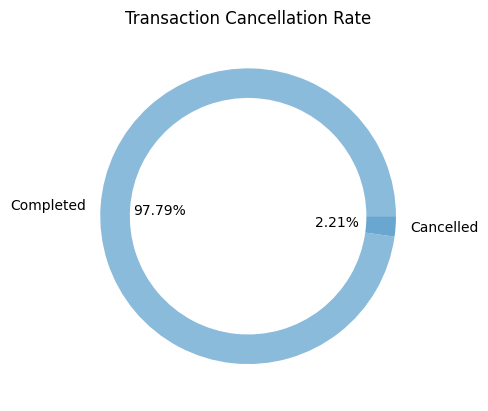

In [12]:
# percentage cancelled transactions
plt.pie(df['transaction_status'].value_counts(), labels = df['transaction_status'].value_counts().index, autopct = '%1.2f%%',
       wedgeprops = {'width':0.2})
plt.title('Transaction Cancellation Rate')
plt.show()

**Insights**
- With 97.79% of transactions completed, the business has a very low cancellation rate, indicating efficient order fulfillment and customer satisfaction.
- This suggests low friction in the purchasing process, meaning customers are likely happy with the service, pricing, and product availability.

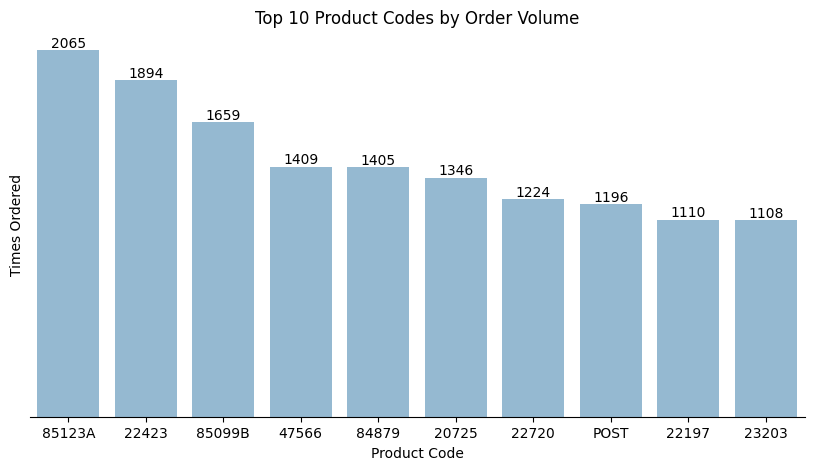

In [13]:
# most frequently ordered stock_code
plt.figure(figsize = (10, 5))

fig = sns.barplot(data = df['stock_code'].value_counts().head(10).values)

plt.title('Top 10 Product Codes by Order Volume')
plt.xlabel('Product Code')
plt.xticks(list(range(0, 10)), list(df['stock_code'].value_counts().head(10).index))
plt.ylabel('Times Ordered')
plt.yticks([])

for patch in fig.patches:
    plt.annotate(f'{patch.get_height():.0f}', (patch.get_x() + patch.get_width() / 2, patch.get_height()), ha = 'center', va = 'bottom')

plt.gca().spines[['top', 'left', 'right']].set_visible(False)

plt.show()

**Note:** The top 10 most ordered items indicate that product codes follow an alphanumeric pattern, with the first character consistently being a number. Any product code that begins with a letter is likely erroneous and should be reviewed and removed as needed.

In [14]:
# erroneous stock_code
df.loc[:, 'flag'] = np.where(df['stock_code'].str.replace(' ', '').str.match('^[^0-9]'), 1, 0)
erroneous_codes = list(df[df['flag'] == 1]['stock_code'].unique())

print(f'Erroneous Stock Codes: {erroneous_codes}')

# removing records with erroneous stock_code and stock_code 23444, 23702 (marked erroneous in project details)
df = df[(df['flag'] != 1) | (df['stock_code'].isin([23444, 23702]))]
df = df.drop('flag', axis = 1)

Erroneous Stock Codes: ['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT', 'CRUK']


In [15]:
# removing all records where unit_price is less than or equals 0
df = df[df['unit_price'] > 0]

### Feature Engineering

In [16]:
# recency
df['date'] = df['invoice_date'].dt.date

recency_data = df.groupby('customer_id')['date'].max().reset_index()
most_recent_date = df['date'].max()

recency_data['date'] = pd.to_datetime(recency_data['date'])
most_recent_date = pd.to_datetime(most_recent_date)

recency_data['days_since_last_purchase'] = (most_recent_date - recency_data['date']).dt.days

recency_data = recency_data.drop('date', axis = 1)

In [17]:
# frequency
total_orders = df.groupby('customer_id')['invoice_number'].nunique().reset_index()
total_orders.rename(columns = {'invoice_number':'total_transactions'}, inplace = True)

total_quantity = df.groupby('customer_id')['quantity'].sum().reset_index()
total_quantity.rename(columns = {'quantity':'total_products_purchase'}, inplace = True)

In [18]:
# consumer data
consumer_data = pd.merge(recency_data, total_orders, on = 'customer_id')
consumer_data = pd.merge(consumer_data, total_quantity, on = 'customer_id')

In [19]:
# monetary
df['total_spend'] = df['unit_price'] * df['quantity']

total_spend = df.groupby('customer_id')['total_spend'].sum().reset_index()

average_transaction_value = pd.merge(total_spend, total_orders, on = 'customer_id')
average_transaction_value['average_transaction_value'] = average_transaction_value['total_spend'] / average_transaction_value['total_transactions']

In [20]:
# consumer data
consumer_data = pd.merge(consumer_data, total_spend, on = 'customer_id')
consumer_data = pd.merge(consumer_data, average_transaction_value, on = 'customer_id')

consumer_data = consumer_data.drop(['total_transactions_y', 'total_spend_y'], axis = 1)
consumer_data.rename(columns = {'total_transactions_x':'total_transactions', 'total_spend_x':'total_spend'}, inplace = True)

In [21]:
# unique products
unique_products = df.groupby('customer_id')['stock_code'].nunique().reset_index()
unique_products.rename(columns = {'stock_code':'unique_products'}, inplace = True)

In [22]:
# consumer data
consumer_data = pd.merge(consumer_data, unique_products, on = 'customer_id')

In [23]:
# average days between purchase
df['date'] = pd.to_datetime(df['date'])
df_copy = df.copy()
df_copy['days_between_purchase'] = df.groupby('customer_id')['date'].diff()
df_copy = df_copy.dropna(subset = 'days_between_purchase')
df_copy['days_between_purchase'] = df_copy['days_between_purchase'].dt.days

average_days_between_purchase = df_copy.groupby('customer_id')['days_between_purchase'].mean().reset_index()
average_days_between_purchase.rename(columns = {'days_between_purchase': 'average_days_between_purchase'}, inplace = True)

In [24]:
# consumer data
consumer_data = pd.merge(consumer_data, average_days_between_purchase, on = 'customer_id')

In [25]:
# favourite shopping day and hour
df['day_of_week'] = df['invoice_date'].dt.dayofweek

favourite_shopping_day = df.groupby(['customer_id', 'day_of_week']).size().reset_index(name = 'count')
favourite_shopping_day = favourite_shopping_day.loc[favourite_shopping_day.groupby('customer_id')['count'].idxmax()]
favourite_shopping_day = favourite_shopping_day[['customer_id', 'day_of_week']]

df['hour'] = df['invoice_date'].dt.hour

favourite_shopping_hour = df.groupby(['customer_id', 'hour']).size().reset_index(name = 'count')
favourite_shopping_hour = favourite_shopping_hour.loc[favourite_shopping_hour.groupby('customer_id')['count'].idxmax()]
favourite_shopping_hour = favourite_shopping_hour[['customer_id', 'hour']]

In [26]:
# consumer data
consumer_data = pd.merge(consumer_data, favourite_shopping_day, on = 'customer_id')
consumer_data = pd.merge(consumer_data, favourite_shopping_hour, on = 'customer_id')

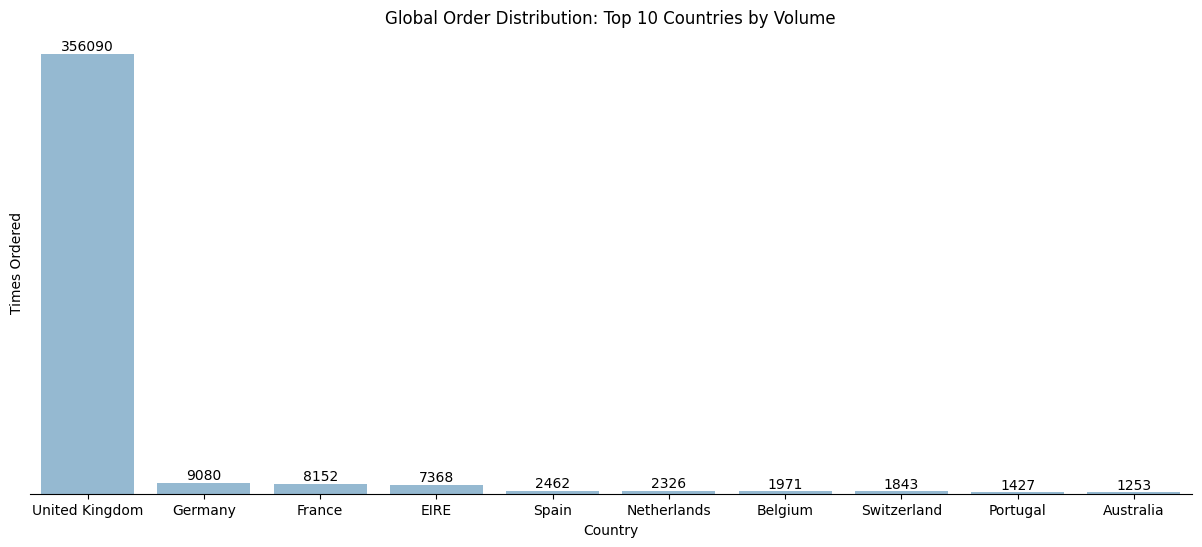

In [27]:
# geographical analysis
data = df.groupby('country').size().sort_values(ascending = False).head(10).reset_index(name = 'number_of_orders')

plt.figure(figsize = (15, 6))
fig = sns.barplot(data = data, x = 'country', y = 'number_of_orders')

for patch in fig.patches:
    plt.annotate(f'{patch.get_height():.0f}', (patch.get_x() + patch.get_width() / 2, patch.get_height()), ha = 'center', va = 'bottom')

plt.title('Global Order Distribution: Top 10 Countries by Volume')
plt.xlabel('Country')
plt.ylabel('Times Ordered')
plt.yticks([])
plt.gca().spines[['top', 'left', 'right']].set_visible(False)
plt.show()

**Note:** The visualization clearly shows that the majority of orders originate from the United Kingdom. To simplify geographic analysis, it is useful to categorize transactions based on whether they are from the UK or another country.

In [28]:
# country data
country_data = df.groupby(['customer_id', 'country']).size().reset_index(name = 'number_of_transactions').sort_values(
    'number_of_transactions', ascending = False).drop_duplicates('customer_id')

country_data['is_UK'] = country_data['country'].apply(lambda x: 1 if x == 'United Kingdom' else 0)

In [29]:
# consumer data
consumer_data = pd.merge(consumer_data, country_data, on = 'customer_id')

In [30]:
# cancellation frequency
cancelled_transactions = df[df['transaction_status'] == 'Cancelled']
cancellation_data = cancelled_transactions.groupby('customer_id')['invoice_number'].nunique().reset_index().rename(
    columns = {'invoice_number':'cancellation_frequency'})

In [31]:
# consumer data
consumer_data = pd.merge(consumer_data, cancellation_data, on = 'customer_id', how = 'left')
consumer_data['cancellation_frequency'] = consumer_data['cancellation_frequency'].fillna(0)

In [32]:
# cancellation rate
consumer_data['cancellation_rate'] = consumer_data['cancellation_frequency'] / consumer_data['total_transactions']

In [33]:
# average monthly spend and standard deviation
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

monthly_spend = df.groupby(['customer_id', 'year', 'month'])['total_spend'].sum().reset_index()
spending_trends = monthly_spend.groupby('customer_id')['total_spend'].agg(['mean', 'std']).reset_index()

spending_trends.rename(columns = {'mean':'average_monthly_spending', 'std':'standard_deviation_monthly_spending'}, inplace = True)

spending_trends = spending_trends.fillna(0)

In [34]:
# consumer data
consumer_data = pd.merge(consumer_data, spending_trends, on = 'customer_id')

In [35]:
# cleaning consumer data
consumer_data['customer_id'] = consumer_data['customer_id'].astype(int).astype(str)
consumer_data = consumer_data.drop(['country', 'number_of_transactions'], axis = 1)

consumer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchase,total_spend,average_transaction_value,unique_products,average_days_between_purchase,day_of_week,hour,is_UK,cancellation_frequency,cancellation_rate,average_monthly_spending,standard_deviation_monthly_spending
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000


In [36]:
# inspecting consumer data
consumer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4285 entries, 0 to 4284
Data columns (total 15 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          4285 non-null   object 
 1   days_since_last_purchase             4285 non-null   int64  
 2   total_transactions                   4285 non-null   int64  
 3   total_products_purchase              4285 non-null   int64  
 4   total_spend                          4285 non-null   float64
 5   average_transaction_value            4285 non-null   float64
 6   unique_products                      4285 non-null   int64  
 7   average_days_between_purchase        4285 non-null   float64
 8   day_of_week                          4285 non-null   int32  
 9   hour                                 4285 non-null   int32  
 10  is_UK                                4285 non-null   int64  
 11  cancellation_frequency        

### Outlier Treatment

In [37]:
# finding average contamination rate for consumer data
numerical_columns = consumer_data.select_dtypes(exclude='object').columns
estimated_contamination_rates = {}

for column in numerical_columns:
    q1 = consumer_data[column].quantile(0.25)
    q3 = consumer_data[column].quantile(0.75)
    iqr = q3 - q1
    
    outlier_condition = (consumer_data[column] < (q1 - 1.5 * iqr)) | (consumer_data[column] > (q3 + 1.5 * iqr))

    outliers = outlier_condition.sum()
    
    contamination_rate = outliers / len(consumer_data)
    
    estimated_contamination_rates[column] = contamination_rate

average_contamination_rate = sum(estimated_contamination_rates.values()) / len(estimated_contamination_rates)
print(f'Average contamination rate: {average_contamination_rate:.2f}')

Average contamination rate: 0.06


In [38]:
# outlier detection
model = IsolationForest(contamination = 0.06, random_state = 1)
consumer_data['outlier_score'] = model.fit_predict(consumer_data.iloc[:, 1:].to_numpy())
consumer_data['is_outlier'] = np.where(consumer_data['outlier_score'] == -1, 1, 0)

consumer_data.head()

,customer_id,days_since_last_purchase,total_transactions,total_products_purchase,total_spend,average_transaction_value,unique_products,average_days_between_purchase,day_of_week,hour,is_UK,cancellation_frequency,cancellation_rate,average_monthly_spending,standard_deviation_monthly_spending,outlier_score,is_outlier
0,12346,325,2,0,0.00,0.000000,1,0.000000,1,10,1,1.0,0.5,0.000000,0.000000,1,0
1,12347,2,7,2458,4310.00,615.714286,103,2.016575,1,14,0,0.0,0.0,615.714286,341.070789,1,0
2,12348,75,4,2332,1437.24,359.310000,21,10.884615,3,19,0,0.0,0.0,359.310000,203.875689,-1,1
3,12349,18,1,630,1457.55,1457.550000,72,0.000000,0,9,0,0.0,0.0,1457.550000,0.000000,-1,1
4,12350,310,1,196,294.40,294.400000,16,0.000000,2,16,0,0.0,0.0,294.400000,0.000000,1,0


In [39]:
# outlier treatment
consumer_data = consumer_data[consumer_data['is_outlier'] == 0]
consumer_data = consumer_data.reset_index(drop = True)
consumer_data = consumer_data.drop(['outlier_score', 'is_outlier'], axis = 1)

### Feature Correlation

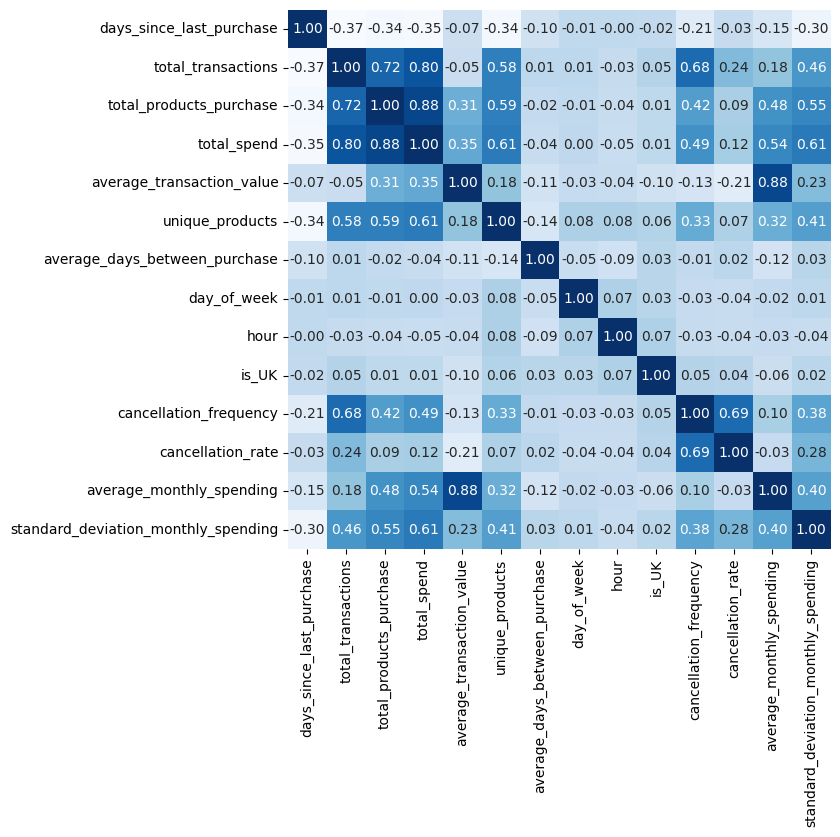

In [40]:
# heatmap
plt.figure(figsize = (7, 7))
sns.heatmap(consumer_data.drop('customer_id', axis = 1).corr(), annot = True, fmt = '0.2f', cmap = 'Blues', cbar = False)
plt.show()

### Feature Reduction

In [41]:
# feature reduction using VIF
x = consumer_data.drop('customer_id', axis=1)

for _ in range(len(x.columns)):  
    vif = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)
    
    high_vif_features = vif[vif > 7]
    
    if high_vif_features.empty:
        break
    
    feature_to_drop = high_vif_features.idxmax()
    x = x.drop(columns=[feature_to_drop])
    
final_vif = pd.Series([variance_inflation_factor(x.values, i) for i in range(x.shape[1])], index=x.columns)
print(final_vif.sort_values(ascending=False))

is_UK                                  5.379071
total_products_purchase                3.576840
cancellation_frequency                 3.371046
average_transaction_value              3.120660
unique_products                        3.119167
cancellation_rate                      2.921740
day_of_week                            2.701806
standard_deviation_monthly_spending    2.504455
days_since_last_purchase               2.063640
average_days_between_purchase          1.176973
dtype: float64


### Scaling Data

In [42]:
# scaling data
columns_to_exclude = final_vif.index
columns_to_scale = consumer_data.columns.intersection(columns_to_exclude)

scaler = StandardScaler()
consumer_data_scaled = scaler.fit_transform(consumer_data[columns_to_scale])

### K-Means Clustering

In [43]:
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 10)
    n_init = trial.suggest_int('n_init', 1, 10)
    max_iter = trial.suggest_int('max_iter', 100, 500)
    tol = trial.suggest_float('tol', 1e-5, 1e-1, log = True)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])

    kmeans = KMeans(n_clusters = n_clusters, init = 'k-means++', n_init = n_init, max_iter = max_iter, tol = tol, verbose = 0,
                    algorithm = algorithm, random_state = 1)
    
    kmeans.fit(consumer_data_scaled)
    
    silhouette = silhouette_score(consumer_data_scaled, kmeans.labels_)
    dbi = davies_bouldin_score(consumer_data_scaled, kmeans.labels_)

    final_score = silhouette - (1 / dbi)

    return final_score

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials = 100)

best_params = study.best_params
model = KMeans(**best_params, init='k-means++', verbose = 0, random_state = 1)
model.fit(consumer_data_scaled)

consumer_data['cluster'] = model.labels_

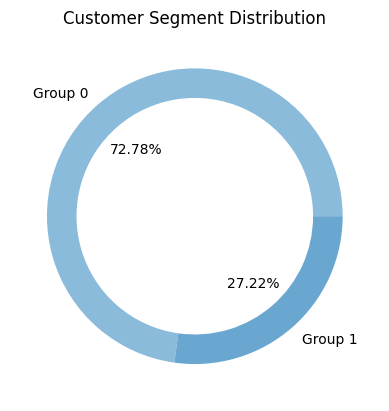

In [44]:
# customer segment distribution
plt.pie(consumer_data['cluster'].value_counts(), labels = ['Group ' + str(i) for i in consumer_data['cluster'].value_counts().index], 
        autopct = '%1.2f%%', wedgeprops = {'width':0.2})
plt.title('Customer Segment Distribution')
plt.show()

In [45]:
# consumer segment analysis
selected_columns = list(final_vif.index)
consumer_data.groupby('cluster')[selected_columns].mean().T

cluster,0,1
days_since_last_purchase,112.896281,35.592153
total_products_purchase,328.464005,1553.876825
average_transaction_value,261.762784,335.881610
unique_products,33.786762,112.015511
average_days_between_purchase,3.414467,2.504598
day_of_week,2.564995,2.562044
is_UK,0.917093,0.934307
cancellation_frequency,0.178437,1.627737
cancellation_rate,0.057643,0.205462
standard_deviation_monthly_spending,51.828815,303.387183


### Insights from Consumer Segment Analysis

**Cluster 0: Infrequent, Low-Value Buyers**
- **Low Engagement:** Last purchase was on average 112 days ago, indicating inactive or churned customers.
- **Lower Purchase Volume:** Bought 328 products on average across transactions.
- **Lower Spending Power:** Average transaction value is \$261.76, indicating budget-conscious shoppers.
- **Limited Variety:** Purchased from ~34 unique products, suggesting focused buying habits.
- **Low Cancellations:** 0.18 cancelled orders on average, with a 5.76% cancellation rate.
- **Consistent Spending:** Standard deviation in monthly spending: $51.83, showing predictable spending patterns.

**Cluster 1: High-Value, Frequent Buyers**
- **Highly Engaged:** Last purchase was just 35 days ago, indicating active and loyal customers.
- **Heavy Buyers:** Bought 1,554 products on average, significantly more than Cluster 0.
- **High Spending Power:** Average transaction value is \$335.88, making them premium customers.
- **Diverse Purchases:** Purchased ~112 unique products, showing broad shopping interests.
- **Higher Cancellations:** 1.63 cancelled orders on average, with a 20.55% cancellation rate, meaning they might order in bulk and return items.
- **Fluctuating Spending:** Standard deviation in monthly spending: $303.39, suggesting variable spending habits (e.g., seasonal spikes or bulk purchases).

### Key Business Takeaways

- **Target Cluster 1 for Loyalty Programs:** They are high-value customers but have a higher cancellation rate. Offering incentives like discounts on future purchases could improve retention.
- **Re-Engage Cluster 0 with Win-Back Campaigns:** Since they are less engaged, targeted promotions (e.g., limited-time offers or personalized recommendations) could bring them back.
- **Investigate High Cancellation Rate in Cluster 1:** Understand why these customers cancel frequently. If it’s due to stock issues or product dissatisfaction, adjustments in inventory or product descriptions may be needed.
- **Leverage Product Recommendations:** Since Cluster 1 buys a wider variety of products, personalized recommendations and cross-selling strategies could further increase revenue.
- **Align Promotional Campaigns with Customer Segments:** Since Cluster 0 is dominant, marketing efforts should primarily cater to their needs while ensuring premium services and personalized engagement for Cluster 1.